In [1]:
import os
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X, method="L1"):
        y_pred = [self._predict(x, method=method) for x in X]
        return np.array(y_pred)

    def _predict(self, x, method="L1"):
        # Compute distances between x and all examples in the training set
        if method=="L1":
            distances = [manhattan_distance(x, x_train) for x_train in self.X_train]
        else:
            distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]
        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # Return the most common class label
        most_common = np.argmax(np.bincount(k_nearest_labels))
        return most_common
    def measure_distances(self, X, method="L1"):
        # Compute distances between x and all examples in the training set
        self.dst_argsort_array=[]
        print("D", end="")
        for index, x in enumerate(X):
            if method=="L1":
                distances = [manhattan_distance(x, x_train) for x_train in self.X_train]
            else:
                distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
            self.dst_argsort_array.append(np.argsort(distances))
            if (index+1) % np.max([int(len(X)/2),1]) ==0:
                print("-50", end="")
            elif (index+1) % np.max([int(len(X)/5),1]) ==0:
                print("-$", end="")
            elif (index+1) % np.max([int(len(X)/20),1]) ==0:
                print("-#", end="")
        print("--Done")
    def predict_by_k(self, k):
        y_pred=[]
        for dst_argsort in self.dst_argsort_array:
            k_indices = dst_argsort[:k]
            # Extract the labels of the k nearest neighbor training samples
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            # print(k_nearest_labels)
            # Return the most common class label
            most_common = np.argmax(np.bincount(k_nearest_labels))
            y_pred.append(most_common)
        return np.array(y_pred)

In [3]:
DATA_DIR = '/content/drive/MyDrive/cifer10'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test')

In [4]:
IMG_SIZE = 32
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)

print(CATEGORIES)

['airplane', 'cat', 'dog', 'deer', 'automobile', 'bird', 'frog', 'truck', 'ship', 'horse']


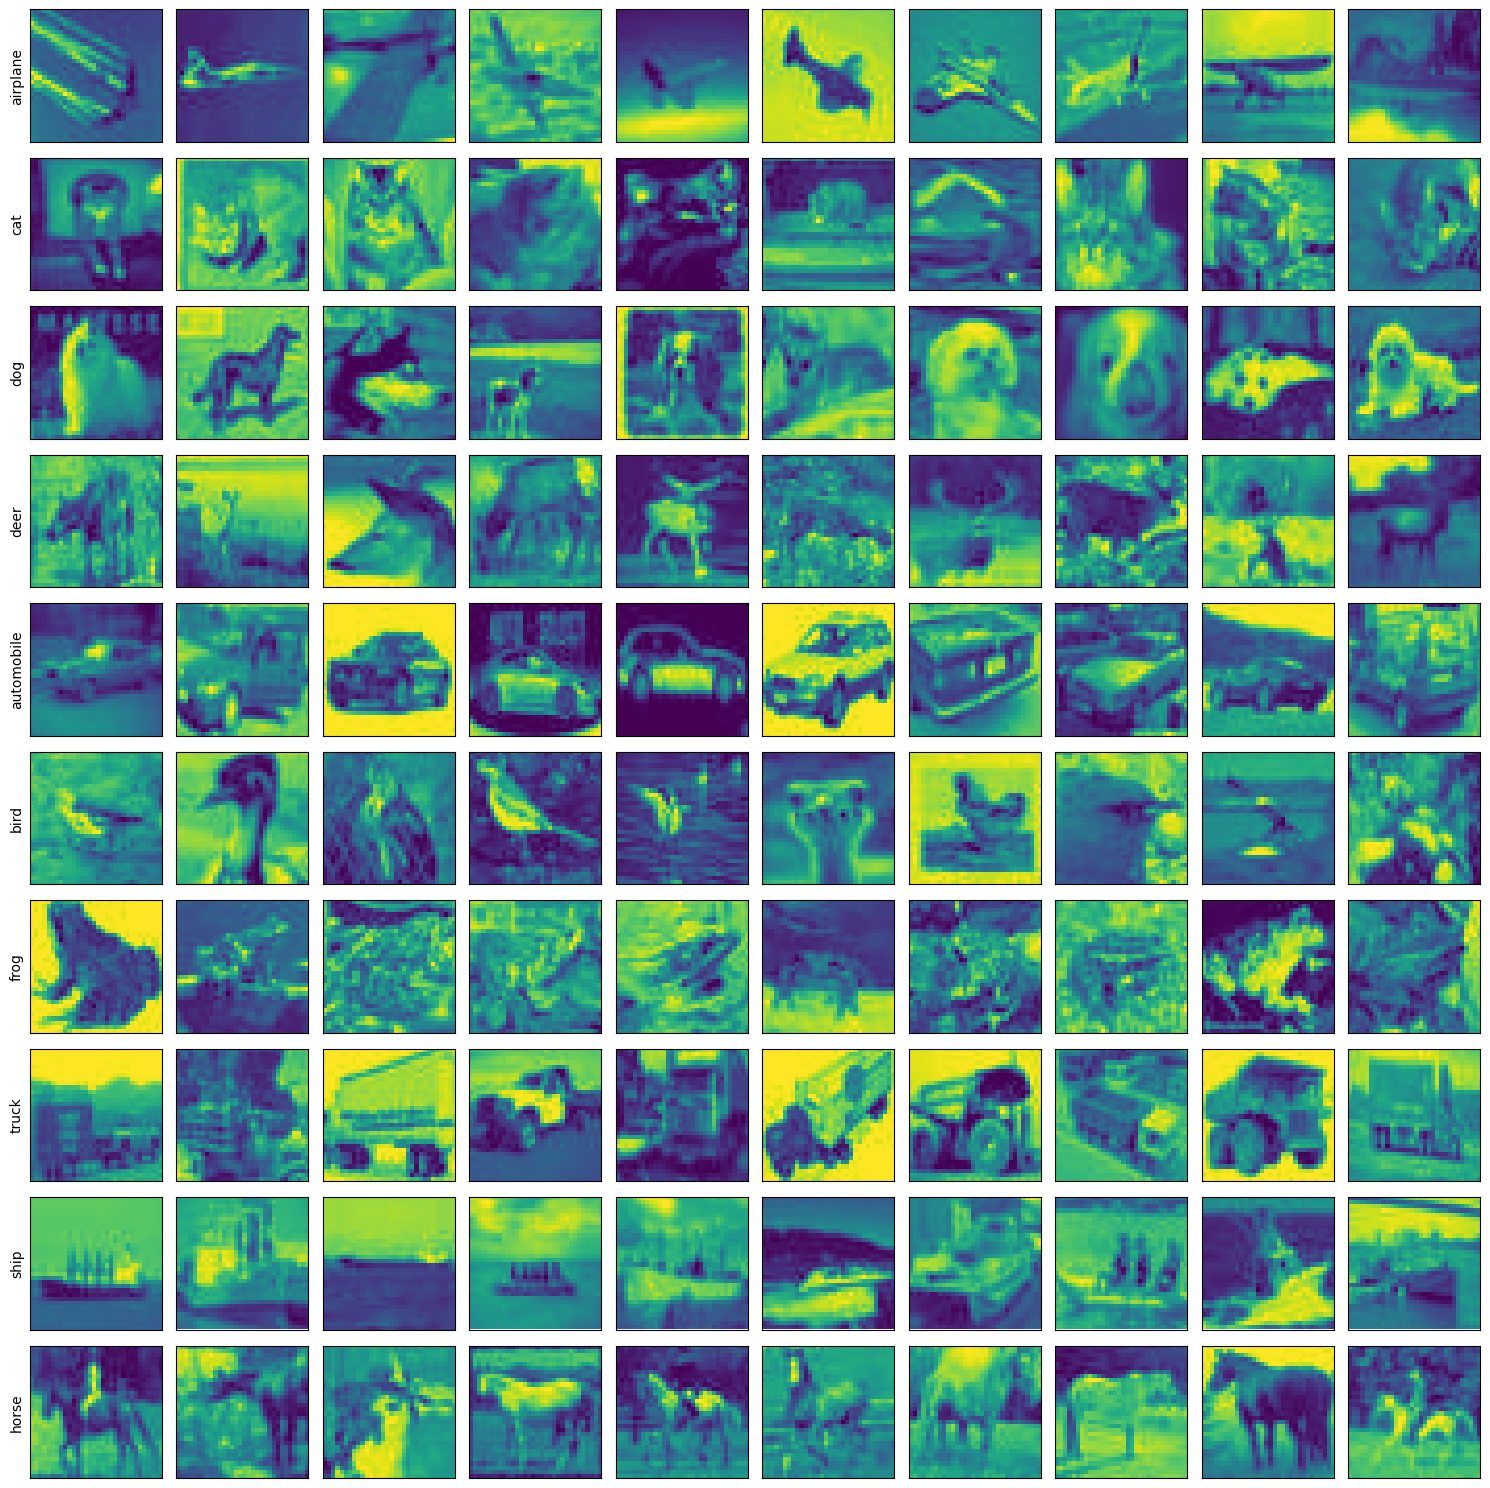

In [5]:
plt.figure(figsize=(15,15))
i=0
for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.subplot(10,10,i+1)
        plt.imshow(img_array)
        if i%10 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%10 == 0:
            break

plt.tight_layout()
plt.show()

In [6]:
training_data = []
for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c) # 0
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)   # read the image
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
            # ershape every image from (32,32) to (1,1024) for convert to 1D List
            training_data.append([np.reshape(img_resized, IMG_SIZE*IMG_SIZE), class_num])
        except WException as e:
            pass

print(len(training_data))

100%|██████████| 5000/5000 [01:10<00:00, 71.12it/s] 

50000


In [7]:
print(training_data[0][0])
print(training_data[0][1])

[125 112 121 ... 115 116 118]
0


In [8]:
from numpy import random
random.shuffle(training_data)
training_data_X = []
training_data_Y = []
for data in training_data:
    training_data_X.append(data[0])
    training_data_Y.append(data[1])



In [9]:
 print(training_data_X[0])
 print(training_data_Y[0:10])

[160 198 180 ... 119 114 116]
[7, 1, 8, 7, 3, 7, 2, 1, 7, 1]


In [10]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.model_selection import KFold

In [11]:
X=np.array(training_data_X[:])
y=np.array(training_data_Y[:])

In [12]:
print(X[0])

[160 198 180 ... 119 114 116]


In [13]:
# Define the number of folds for cross-validation
k_folds = 5
result1=[]
# Create a KNN classifier with k=3
knn3 = KNN()
# Perform cross-validation
kf = KFold(n_splits=k_folds)
for train_index, test_index in kf.split(X):
    #print("k-fold")
    # Split the data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the classifier
    knn3.fit(X_train, y_train)

    #measure distances
    knn3.measure_distances(X_test, method="L1")
    # Make predictions on the test set
    accuracies1 = []
    x_axis1=[]
    print("k", end="")
    for i in range(1,100):
        x_axis1.append(i)
        y_pred = knn3.predict_by_k(i)
        # Calculate the accuracy of the classifier for this fold
        accuracy = accuracy_score(y_test, y_pred)
        accuracies1.append(accuracy)
        if (i+1)%5==0:
            print("-#",end="")
    print("--Done")
    result1.append(accuracies1)



D-#-#-#-$-#-#-#-$-#-50-#-$-#-#-#-$-#-#-#-50--Done
k-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#--Done
D-#-#-#-$-#-#-#-$-#-50-#-$-#-#-#-$-#-#-#-50--Done
k-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#--Done
D-#-#-#-$-#-#-#-$-#-50-#-$-#-#-#-$-#-#-#-50--Done
k-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#--Done
D-#-#-#-$-#-#-#-$-#-50-#-$-#-#-#-$-#-#-#-50--Done
k-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#--Done
D-#-#-#-$-#-#-#-$-#-50-#-$-#-#-#-$-#-#-#-50--Done
k-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#--Done


In [14]:
# Define the number of folds for cross-validation
k_folds = 5
result2=[]
# Create a KNN classifier with k=3
knn4 = KNN()
# Perform cross-validation
kf = KFold(n_splits=k_folds)
for train_index, test_index in kf.split(X):
    #print("k-fold")
    # Split the data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the classifier
    knn4.fit(X_train, y_train)

    #measure distances
    knn4.measure_distances(X_test, method="L2")
    # Make predictions on the test set
    accuracies2 = []
    x_axis2=[]
    print("K",end="")
    for i in range(1,100):
        x_axis2.append(i)
        y_pred = knn4.predict_by_k(i)
        # Calculate the accuracy of the classifier for this fold
        accuracy2 = accuracy_score(y_test, y_pred)
        accuracies2.append(accuracy2)
        if (i+1)%5==0:
            print("-#",end="")
    print("--Done")
    result2.append(accuracies2)

D-#-#-#-$-#-#-#-$-#-50-#-$-#-#-#-$-#-#-#-50--Done
K-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#--Done
D-#-#-#-$-#-#-#-$-#-50-#-$-#-#-#-$-#-#-#-50--Done
K-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#--Done
D-#-#-#-$-#-#-#-$-#-50-#-$-#-#-#-$-#-#-#-50--Done
K-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#--Done
D-#-#-#-$-#-#-#-$-#-50-#-$-#-#-#-$-#-#-#-50--Done
K-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#--Done
D-#-#-#-$-#-#-#-$-#-50-#-$-#-#-#-$-#-#-#-50--Done
K-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#--Done


In [15]:
y_axis1=[]
for i in np.transpose(result1):
    average_accuracy = np.mean(i)
    y_axis1.append(average_accuracy)
    #print("Average Accuracy:", average_accuracy)
print("For L1: ")
print(x_axis1[0:10])
print(y_axis1[0:10])

y_axis2=[]
for i in np.transpose(result2):
    average_accuracy = np.mean(i)
    y_axis2.append(average_accuracy)
    #print("Average Accuracy:", average_accuracy)
print("For L2: ")
print(x_axis2[0:10])
print(y_axis2[0:10])

For L1: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.22766000000000003, 0.20146000000000003, 0.21679999999999996, 0.22557999999999997, 0.23156, 0.23264, 0.23564, 0.23722, 0.23759999999999998, 0.23837999999999998]
For L2: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.18928, 0.16433999999999999, 0.16543999999999998, 0.16448000000000002, 0.16650000000000004, 0.16452, 0.16568, 0.1638, 0.16442, 0.16258]


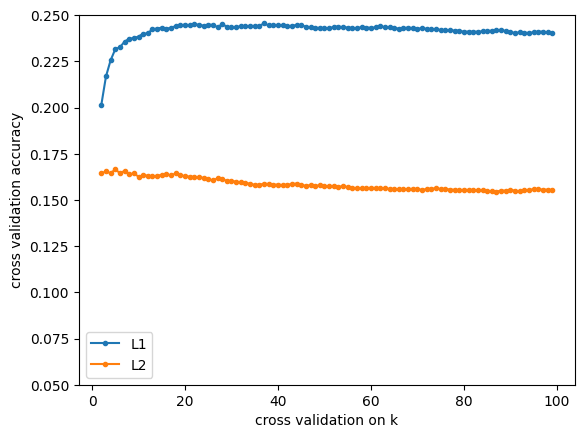

In [16]:
plt.figsize=(15,15)
x1 = np.array(x_axis1[1:])
y1 = np.array(y_axis1[1:])

x2 = np.array(x_axis2[1:])
y2 = np.array(y_axis2[1:])

plt.plot(x1, y1, label="L1", marker = '.')
plt.plot(x2, y2, label="L2", marker = '.')
plt.legend()
plt.ylim((0.05,0.25))
plt.xlabel("cross validation on k")
plt.ylabel("cross validation accuracy")
plt.show()

In [17]:
print("For L1:")
print("Max accuracy: ", np.max(y_axis1[1:]))
print("Value of K: ", x_axis1[np.argmax(y_axis1[1:])])
print()
print("For L2:")
print("Max accuracy: ", np.max(y_axis2[1:]))
print("Value of K: ", x_axis2[np.argmax(y_axis2[1:])])

For L1:
Max accuracy:  0.24556
Value of K:  36

For L2:
Max accuracy:  0.16650000000000004
Value of K:  4


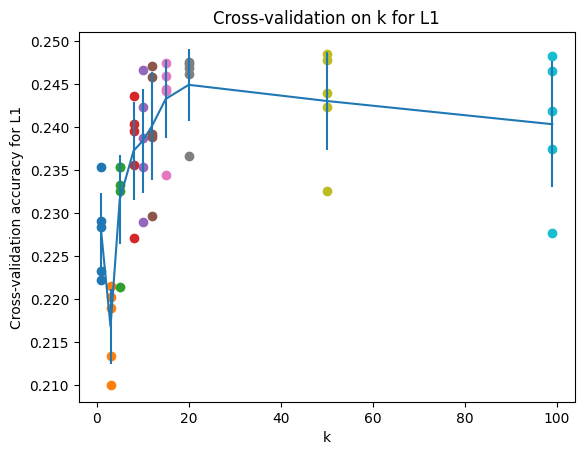

In [18]:
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 99]
k_to_accuracies={}
for k in k_choices:
  k_to_accuracies[k]=np.transpose(result1)[k-1]
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k for L1')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy for L1')
plt.show()

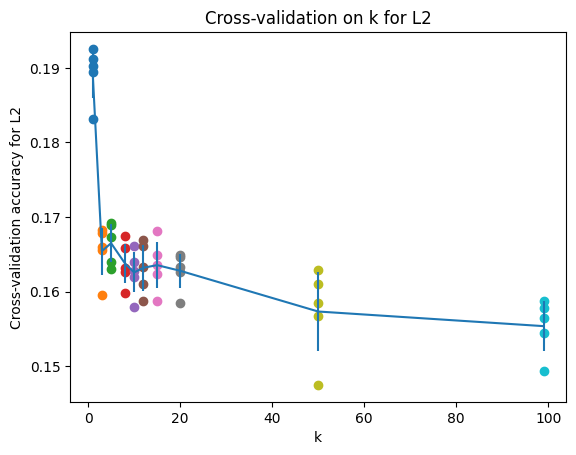

In [19]:
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 99]
k_to_accuracies={}
for k in k_choices:
  k_to_accuracies[k]=np.transpose(result2)[k-1]
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k for L2')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy for L2')
plt.show()